In [32]:
# Carregamento e preparação do dataset NIH Chest X-rays

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121, mobilenet_v3_large
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import BorderlineSMOTE

dataset_percentage = 1
batch_size = 32
learning_rate = 0.001
num_epochs = 100
num_classes = 3
usar_adaptacao_lr_fuzzy = True
early_stopping_patience = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = os.path.join('data', 'nih-chest-xrays', 'data')
images_dir = os.path.join(data_dir, 'images')
csv_path = os.path.join(data_dir, 'Data_Entry_2017.csv')
print(csv_path)

print("Carregando dados do CSV...")
df = pd.read_csv(csv_path)

if dataset_percentage < 1.0:
    print(f"Usando apenas {dataset_percentage*100}% do dataset original")
    df = df.sample(frac=dataset_percentage, random_state=42)

print("\nAnalisando categorias de imagens no dataset original:")
finding_counts = df['Finding Labels'].str.split('|', expand=True).stack().value_counts()
print("Distribuição das categorias de achados:")
print(finding_counts)

pacientes_com_doenca = df[df['Finding Labels'] != 'No Finding']['Patient ID'].unique()
print(f"\nNúmero de pacientes com pelo menos uma imagem com alguma doença: {len(pacientes_com_doenca)}")

no_finding_de_pacientes_com_doenca = df[
    (df['Finding Labels'] == 'No Finding') & 
    (df['Patient ID'].isin(pacientes_com_doenca))
]

print(f"\nNúmero de imagens 'No Finding' de pacientes que possuem alguma doença: {len(no_finding_de_pacientes_com_doenca)}")

if len(no_finding_de_pacientes_com_doenca) > 0:
    print("\nExemplos de imagens 'No Finding' de pacientes com doença:")
    print(no_finding_de_pacientes_com_doenca[['Image Index', 'Patient ID', 'Finding Labels']].head())

df = df[~((df['Finding Labels'] == 'No Finding') & (df['Patient ID'].isin(pacientes_com_doenca)))]
print(f"\nTamanho do DataFrame após remover 'No Finding' de pacientes com doença: {len(df)}")

pneumonia_count = df[df['Finding Labels'].str.contains('Pneumonia')].shape[0]
print(f"Imagens com Pneumonia: {pneumonia_count}")

pneumothorax_count = df[df['Finding Labels'].str.contains('Pneumothorax')].shape[0]
print(f"Imagens com Pneumothorax: {pneumothorax_count}")

no_finding_count = df[df['Finding Labels'] == 'No Finding'].shape[0]
print(f"Imagens sem achados (No Finding): {no_finding_count}")

pneumonia_and_pneumothorax = df[df['Finding Labels'].str.contains('Pneumonia') & 
                               df['Finding Labels'].str.contains('Pneumothorax')].shape[0]
print(f"Imagens com Pneumonia e Pneumothorax simultaneamente: {pneumonia_and_pneumothorax}")

print("\nExemplos de entradas com múltiplas condições:")
print(df[df['Finding Labels'].str.contains('\|')].head(3)['Finding Labels'])

def classificar_doenca(finding_labels):
    if finding_labels == "No Finding":
        return "Nada"
    elif finding_labels.find("Pneumonia") != -1 and finding_labels.find("Pneumothorax") == -1:
        return "Pneumonia"
    elif finding_labels.find("Pneumothorax") != -1 and finding_labels.find("Pneumonia") == -1:
        return "Pneumothorax"
    else:
        return "Outro"

df['disease_class'] = df['Finding Labels'].apply(classificar_doenca)

print("\nRemovendo entradas que não são Nada, Pneumonia ou Pneumothorax...")
print(f"Tamanho do DataFrame antes da remoção: {len(df)}")
df = df[df['disease_class'] != 'Outro']
print(f"Tamanho do DataFrame após a remoção: {len(df)}")

df['disease_class'] = df['Finding Labels'].apply(classificar_doenca)


print("\nDistribuição das classes:")
print(df['disease_class'].value_counts())

def balancear_classes_por_reducao(dataframe):
    print("\nBalanceando classes por redução da classe majoritária...")
    contagem_classes = dataframe['disease_class'].value_counts()
    print(f"Distribuição original: {contagem_classes}")
    
    min_class_count = contagem_classes.min()
    
    df_balanceado = pd.DataFrame()
    
    for classe in contagem_classes.index:
        df_classe = dataframe[dataframe['disease_class'] == classe]
        df_classe_reduzida = df_classe.sample(min_class_count, random_state=42)
        df_balanceado = pd.concat([df_balanceado, df_classe_reduzida])
    
    print(f"Distribuição após balanceamento: {df_balanceado['disease_class'].value_counts()}")
    return df_balanceado

def balancear_classes_com_smote(dataframe, img_dir):
    print("\nBalanceando classes com BorderlineSMOTE...")
    
    X = []
    y = []
    
    for idx, row in dataframe.iterrows():
        img_path = os.path.join(img_dir, row['Image Index'])
        try:
            img = np.array(Image.open(img_path).convert('L').resize((224, 224)))
            X.append(img.flatten())
            
            if row['disease_class'] == 'Nada':
                y.append(0)
            elif row['disease_class'] == 'Pneumonia':
                y.append(1)
            elif row['disease_class'] == 'Pneumothorax':
                y.append(2)
        except Exception as e:
            print(f"Erro ao processar imagem {img_path}: {e}")
            continue
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Distribuição original: {pd.Series(y).value_counts()}")
    
    smote = BorderlineSMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    
    print(f"Distribuição após SMOTE: {pd.Series(y_res).value_counts()}")
    
    # Criar um novo DataFrame com as amostras balanceadas
    df_balanceado = pd.DataFrame()
    
    # Adicionar amostras originais
    original_indices = []
    for i, x_res in enumerate(X_res):
        for j, x in enumerate(X):
            if np.array_equal(x_res, x):
                original_indices.append(j)
                break
    
    df_original = dataframe.iloc[original_indices].copy()
    
    # Salvar imagens sintéticas
    os.makedirs('./imagens_criadas_por_boordeline', exist_ok=True)
    synthetic_indices = [i for i in range(len(X_res)) if i not in range(len(X))]
    
    for i in synthetic_indices:
        img_array = X_res[i].reshape(224, 224)
        img = Image.fromarray(img_array.astype('uint8'), 'L')
        img.save(f'./imagens_criadas_por_boordeline/synthetic_{i}.jpg')
    
    # Criar entradas para amostras sintéticas
    synthetic_indices = [i for i in range(len(X_res)) if i not in range(len(X))]
    synthetic_samples = []
    
    for i in synthetic_indices:
        classe = int(y_res[i])
        classe_nome = 'Nada' if classe == 0 else ('Pneumonia' if classe == 1 else 'Pneumothorax')
        
        # Criar uma entrada similar às originais para amostras sintéticas
        synthetic_sample = dataframe.iloc[0].copy()
        synthetic_sample['disease_class'] = classe_nome
        synthetic_sample['Finding Labels'] = classe_nome if classe_nome != 'Nada' else 'No Finding'
        synthetic_sample['Image Index'] = f"synthetic_{i}.png"  # Nome fictício
        synthetic_sample['is_synthetic'] = True
        
        synthetic_samples.append(synthetic_sample)
    
    # Adicionar flag para amostras originais
    df_original['is_synthetic'] = False
    
    # Combinar amostras originais e sintéticas
    df_balanceado = pd.concat([df_original, pd.DataFrame(synthetic_samples)])
    
    print(f"Amostras originais: {len(df_original)}")
    print(f"Amostras sintéticas: {len(synthetic_samples)}")
    print("Nota: As amostras sintéticas foram adicionadas ao DataFrame com marcação 'is_synthetic'")
    
    return df_balanceado, X_res, y_res

def reduzir_classe_nada(dataframe):
    df_nada = dataframe[dataframe['disease_class'] == 'Nada']
    df_outras_classes = dataframe[dataframe['disease_class'] != 'Nada']
    
    df_nada_reduzido = df_nada.sample(frac=0.25, random_state=42)
    
    df_balanceado = pd.concat([df_nada_reduzido, df_outras_classes])
    
    print(f"Distribuição original: Total={len(dataframe)}, Nada={len(df_nada)}, Outras={len(df_outras_classes)}")
    print(f"Distribuição após redução: Total={len(df_balanceado)}, Nada={len(df_nada_reduzido)}, Outras={len(df_outras_classes)}")
    
    return df_balanceado

df = reduzir_classe_nada(df)

df_balanceado, X_smote, y_smote = balancear_classes_com_smote(df, images_dir)
print('Tamanho da janela de dados pós balanceamento de classes:', len(df_balanceado))

class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, X_smote=None, y_smote=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.X_smote = X_smote
        self.y_smote = y_smote
        
        self.class_to_idx = {"Nada": 0,"Pneumonia": 1, "Pneumothorax": 2}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        if 'is_synthetic' in row and row['is_synthetic']:
            # Para amostras sintéticas, recuperar do X_smote
            synthetic_idx = int(row['Image Index'].split('_')[1].split('.')[0])
            img_data = self.X_smote[synthetic_idx].reshape(224, 224)
            image = Image.fromarray(img_data.astype(np.uint8), 'L').convert('RGB')
        else:
            # Para amostras reais, carregar do disco
            img_name = row['Image Index']
            img_path = os.path.join(self.img_dir, img_name)
            image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = row['disease_class']
        label_idx = self.class_to_idx[label]
        
        return image, label_idx

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("\nDividindo o dataset...")
train_df, temp_df = train_test_split(df_balanceado, test_size=0.3, random_state=42, stratify=df_balanceado['disease_class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['disease_class'])

print(f"Tamanho do conjunto de treino: {len(train_df)}")
print(f"Tamanho do conjunto de validação: {len(val_df)}")
print(f"Tamanho do conjunto de teste: {len(test_df)}")

train_dataset = ChestXRayDataset(train_df, images_dir, transform=train_transform, X_smote=X_smote, y_smote=y_smote)
val_dataset = ChestXRayDataset(val_df, images_dir, transform=val_test_transform, X_smote=X_smote, y_smote=y_smote)
test_dataset = ChestXRayDataset(test_df, images_dir, transform=val_test_transform, X_smote=X_smote, y_smote=y_smote)

class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        
        self.base_model = mobilenet_v3_large(weights='IMAGENET1K_V1')
        
        for i, param in enumerate(self.base_model.parameters()):
            if i < 100:
                param.requires_grad = False
            else:
                param.requires_grad = True
            
        num_ftrs = self.base_model.classifier[0].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.Hardswish(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.Hardswish(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.base_model(x)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = CNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

def criar_sistema_fuzzy():
    tendencia_perda = ctrl.Antecedent(np.linspace(-0.05, 0.05, 100), 'tendencia_perda')
    variacao_acuracia = ctrl.Antecedent(np.linspace(-5, 5, 100), 'variacao_acuracia')
    
    delta_lr = ctrl.Consequent(np.linspace(-0.5, 0.5, 100), 'delta_lr')
    
    tendencia_perda['diminuindo_rapido'] = fuzz.trimf(tendencia_perda.universe, [-0.05, -0.05, -0.025])
    tendencia_perda['diminuindo_lento'] = fuzz.trimf(tendencia_perda.universe, [-0.025, -0.0125, 0])
    tendencia_perda['estavel'] = fuzz.trimf(tendencia_perda.universe, [-0.015, 0, 0.015])
    tendencia_perda['aumentando_lento'] = fuzz.trimf(tendencia_perda.universe, [0, 0.0125, 0.025])
    tendencia_perda['aumentando_rapido'] = fuzz.trimf(tendencia_perda.universe, [0.025, 0.05, 0.05])
    
    variacao_acuracia['piorando'] = fuzz.trimf(variacao_acuracia.universe, [-5, -5, -1])
    variacao_acuracia['estavel'] = fuzz.trimf(variacao_acuracia.universe, [-1.5, 0, 1.5])
    variacao_acuracia['melhorando_lento'] = fuzz.trimf(variacao_acuracia.universe, [0.5, 1.5, 2.5])
    variacao_acuracia['melhorando_rapido'] = fuzz.trimf(variacao_acuracia.universe, [1.5, 5, 5])
    
    delta_lr['diminuir_muito'] = fuzz.trimf(delta_lr.universe, [-0.5, -0.5, -0.3])
    delta_lr['diminuir_pouco'] = fuzz.trimf(delta_lr.universe, [-0.3, -0.1, 0])
    delta_lr['manter'] = fuzz.trimf(delta_lr.universe, [-0.05, 0, 0.05])
    delta_lr['aumentar_pouco'] = fuzz.trimf(delta_lr.universe, [0, 0.1, 0.3])
    delta_lr['aumentar_muito'] = fuzz.trimf(delta_lr.universe, [0.3, 0.5, 0.5])
    
    regra1 = ctrl.Rule(tendencia_perda['aumentando_rapido'] | variacao_acuracia['piorando'], delta_lr['diminuir_muito'])
    regra2 = ctrl.Rule(tendencia_perda['aumentando_lento'] | variacao_acuracia['piorando'], delta_lr['diminuir_pouco'])
    regra3 = ctrl.Rule(tendencia_perda['estavel'] | variacao_acuracia['estavel'], delta_lr['manter'])
    regra4 = ctrl.Rule(tendencia_perda['diminuindo_lento'] | variacao_acuracia['melhorando_lento'], delta_lr['manter'])
    regra5 = ctrl.Rule(tendencia_perda['diminuindo_rapido'] | variacao_acuracia['melhorando_rapido'], delta_lr['aumentar_pouco'])
    regra6 = ctrl.Rule(tendencia_perda['diminuindo_rapido'] | variacao_acuracia['estavel'], delta_lr['aumentar_pouco'])
    regra7 = ctrl.Rule(tendencia_perda['aumentando_lento'] | variacao_acuracia['melhorando_lento'], delta_lr['diminuir_pouco'])
    regra8 = ctrl.Rule(tendencia_perda['estavel'] | variacao_acuracia['piorando'], delta_lr['diminuir_pouco'])
    regra9 = ctrl.Rule(tendencia_perda['estavel'] | variacao_acuracia['melhorando_rapido'], delta_lr['aumentar_pouco'])
    
    regra10 = ctrl.Rule(tendencia_perda['aumentando_rapido'] | variacao_acuracia['estavel'], delta_lr['diminuir_pouco'])
    regra11 = ctrl.Rule(tendencia_perda['aumentando_rapido'] | variacao_acuracia['melhorando_lento'], delta_lr['diminuir_pouco'])
    regra12 = ctrl.Rule(tendencia_perda['aumentando_rapido'] | variacao_acuracia['melhorando_rapido'], delta_lr['manter'])
    regra13 = ctrl.Rule(tendencia_perda['aumentando_lento'] | variacao_acuracia['estavel'], delta_lr['diminuir_pouco'])
    regra14 = ctrl.Rule(tendencia_perda['aumentando_lento'] | variacao_acuracia['melhorando_rapido'], delta_lr['manter'])
    regra15 = ctrl.Rule(tendencia_perda['diminuindo_lento'] | variacao_acuracia['piorando'], delta_lr['diminuir_pouco'])
    regra16 = ctrl.Rule(tendencia_perda['diminuindo_lento'] | variacao_acuracia['estavel'], delta_lr['manter'])
    regra17 = ctrl.Rule(tendencia_perda['diminuindo_rapido'] | variacao_acuracia['piorando'], delta_lr['diminuir_pouco'])
    regra18 = ctrl.Rule(tendencia_perda['diminuindo_rapido'] | variacao_acuracia['melhorando_lento'], delta_lr['aumentar_pouco'])
    
    sistema_controle = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6, regra7, regra8, regra9,
                                          regra10, regra11, regra12, regra13, regra14, regra15, regra16, regra17, regra18])
    sistema = ctrl.ControlSystemSimulation(sistema_controle)
    
    return sistema

def calcular_ajuste_lr(historico_perdas, historico_acuracias, sistema_fuzzy):
    if len(historico_perdas) < 1:
        return 0.0
    
    tendencia = np.mean([historico_perdas[i] - historico_perdas[i-1] for i in range(len(historico_perdas)-4, len(historico_perdas))])
    
    variacao_acc = historico_acuracias[-1] - historico_acuracias[-5]
    
    tendencia = max(min(tendencia, 0.2), -0.2)
    variacao_acc = max(min(variacao_acc, 10), -10)
    
    try:
        sistema_fuzzy.input['tendencia_perda'] = tendencia
        sistema_fuzzy.input['variacao_acuracia'] = variacao_acc
        sistema_fuzzy.compute()
        print()
        return sistema_fuzzy.output['delta_lr']
    except ValueError as e:
        print(f"Aviso: Erro no sistema fuzzy com tendência={tendencia:.4f}, variação={variacao_acc:.4f}. {str(e)}")
        if tendencia > 0.05:
            return -0.2
        elif tendencia > 0:
            return -0.1
        elif tendencia < -0.05:
            return 0.1
        else:
            return 0.0

best_val_loss = float('inf')
early_stopping_counter = 0

print("\nTreinando modelo CNN...")
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

sistema_fuzzy = None
if usar_adaptacao_lr_fuzzy:
    sistema_fuzzy = criar_sistema_fuzzy()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    if usar_adaptacao_lr_fuzzy and epoch > 0 and epoch % 5 == 0:
        delta_lr = calcular_ajuste_lr(train_losses, train_accuracies, sistema_fuzzy)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        new_lr = max(1e-6, current_lr * (1 + delta_lr))
        
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        
        print(f'Learning rate ajustado: {current_lr:.6f} -> {new_lr:.6f} (delta: {delta_lr:.4f})')
    
    print(f'Época [{epoch+1}/{num_epochs}], Perda Treino: {train_loss:.4f}, Perda Validação: {val_loss:.4f}, Acurácia Treino: {train_accuracy:.2f}%, Acurácia Validação: {val_accuracy:.2f}%')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Melhor modelo salvo com perda de validação: {best_val_loss:.4f}")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping ativado na época {epoch+1}")
            break


data\nih-chest-xrays\data\Data_Entry_2017.csv
Carregando dados do CSV...

Analisando categorias de imagens no dataset original:
Distribuição das categorias de achados:
No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
Name: count, dtype: int64

Número de pacientes com pelo menos uma imagem com alguma doença: 14402

Número de imagens 'No Finding' de pacientes que possuem alguma doença: 36565

Exemplos de imagens 'No Finding' de pacientes com doença:
         Image Index  Patient ID Finding Labels
13  00000005_000.png           5     No Finding
14  00000005_001.png           5     No Finding
15  00000005_002.png           5 

ValueError: cannot reshape array of size 1024 into shape (224,224)

In [ ]:
best_val_loss = float('inf')
early_stopping_counter = 0

print("\nTreinando modelo CNN...")
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

sistema_fuzzy = None
if usar_adaptacao_lr_fuzzy:
    sistema_fuzzy = criar_sistema_fuzzy()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct / total
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    if usar_adaptacao_lr_fuzzy and epoch > 0 and epoch % 5 == 0:
        delta_lr = calcular_ajuste_lr(train_losses, train_accuracies, sistema_fuzzy)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        new_lr = max(1e-6, current_lr * (1 + delta_lr))
        
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        
        print(f'Learning rate ajustado: {current_lr:.6f} -> {new_lr:.6f} (delta: {delta_lr:.4f})')
    
    print(f'Época [{epoch+1}/{num_epochs}], Perda Treino: {train_loss:.4f}, Perda Validação: {val_loss:.4f}, Acurácia Treino: {train_accuracy:.2f}%, Acurácia Validação: {val_accuracy:.2f}%')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Melhor modelo salvo com perda de validação: {best_val_loss:.4f}")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping ativado na época {epoch+1}")
            break


Treinando modelo CNN...
Época [1/100], Perda Treino: 0.2335, Perda Validação: 0.5750, Acurácia Treino: 91.73%, Acurácia Validação: 81.68%
Melhor modelo salvo com perda de validação: 0.5750
Época [2/100], Perda Treino: 0.2274, Perda Validação: 0.6650, Acurácia Treino: 91.91%, Acurácia Validação: 80.86%
Época [3/100], Perda Treino: 0.2284, Perda Validação: 0.5899, Acurácia Treino: 91.75%, Acurácia Validação: 81.31%
Época [4/100], Perda Treino: 0.2200, Perda Validação: 0.5841, Acurácia Treino: 91.95%, Acurácia Validação: 82.01%
Época [5/100], Perda Treino: 0.2159, Perda Validação: 0.6258, Acurácia Treino: 92.15%, Acurácia Validação: 81.64%
1.2142958413676672e-17
Learning rate ajustado: 0.001000 -> 0.001000 (delta: 0.0000)
Época [6/100], Perda Treino: 0.2194, Perda Validação: 0.6567, Acurácia Treino: 92.14%, Acurácia Validação: 78.51%


KeyboardInterrupt: 


Desempenho do modelo CNN no conjunto de teste:
              precision    recall  f1-score   support

        Nada       0.84      0.90      0.87       893
   Pneumonia       0.84      0.82      0.83       895
Pneumothorax       0.80      0.76      0.78       893

    accuracy                           0.83      2681
   macro avg       0.83      0.83      0.83      2681
weighted avg       0.83      0.83      0.83      2681


Matriz de Confusão do modelo CNN:


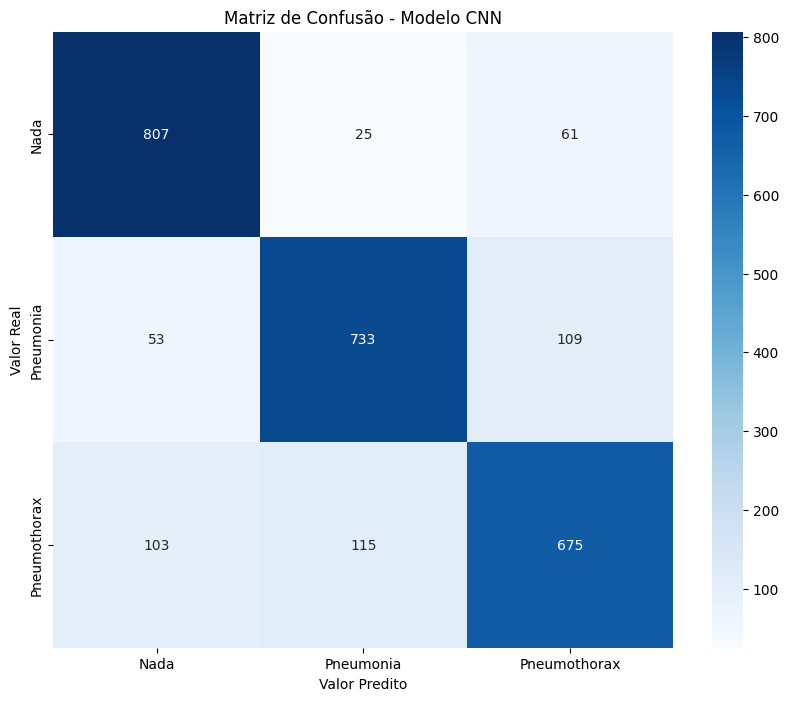

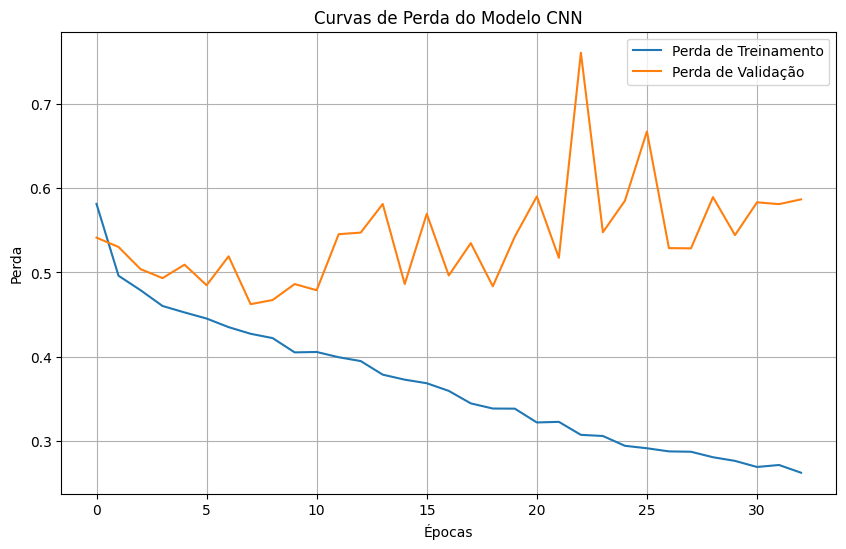

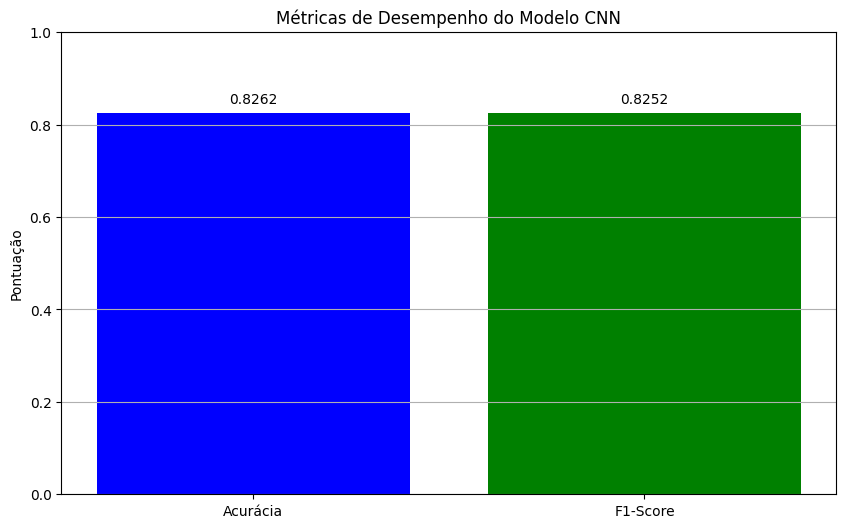

In [26]:
model.load_state_dict(torch.load('best_model.pth'))
print("Melhor modelo carregado para avaliação")
# Avaliação no conjunto de teste
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Mapeamento de índices para nomes de classes
class_names = {0: "Nada", 1: "Pneumonia", 2: "Pneumothorax"}
target_names = [class_names[i] for i in range(len(class_names))]

# Relatório de classificação
print("\nDesempenho do modelo CNN no conjunto de teste:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Matriz de confusão
print("\nMatriz de Confusão do modelo CNN:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Matriz de Confusão - Modelo CNN')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()

# Calculando métricas para plotagem
from sklearn.metrics import accuracy_score, f1_score

# Plotando as perdas de treinamento e validação
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Perda de Treinamento')
plt.plot(val_losses, label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Curvas de Perda do Modelo CNN')
plt.legend()
plt.grid(True)
plt.show()

# Plotando acurácia e F1-score
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

plt.figure(figsize=(10, 6))
plt.bar(['Acurácia', 'F1-Score'], [accuracy, f1], color=['blue', 'green'])
plt.ylim(0, 1)
plt.title('Métricas de Desempenho do Modelo CNN')
plt.ylabel('Pontuação')
plt.grid(axis='y')
for i, v in enumerate([accuracy, f1]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.show()